In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sunRay.densityModel as dm
import torch
from mpl_toolkits.mplot3d import Axes3D
import timeit
from torch.autograd import grad

In [2]:
verbose = True
GPU_all = False

if GPU_all:
    torch.set_default_tensor_type('torch.cuda.FloatTensor') 
    # use gpu for everything
else:
    torch.set_default_tensor_type('torch.FloatTensor') 
    # use cpu for everything

# initialize
photon_N = 100
steps_N = 2000
t_delta = 0.001
start_r = 2 # in solar radii
start_theta = 0 # in rad
start_phi  = 0 # in rad

r_Sun = 6.96e10 # [cm]
c = 2.998e10    # [cm s^(-1)]
c_r=c/r_Sun     # [s^(-1)]

f_ratio  = 2
density_r = dm.leblanc98 # [cm^(-3)] 
# use saito77 for this calculation 

@torch.enable_grad()
def omega_pe_r(r):
    # Ne with plasma frequency density relationship
    return 8.98e3* (density_r(r))**0.5 * 2 * np.pi

@torch.enable_grad()
def v_abs(v): # length of the vector
    # for torch tensor in shape 3*N
    return torch.sqrt(torch.sum(v.pow(2.),axis=0))
    

freq0 = f_ratio * omega_pe_r(start_r)/(2*np.pi)

if verbose:
    print('Frequency(MHz) : '+str(freq0/1e6))
    print('Omega(M rad/s) : '+str(f_ratio * omega_pe_r(start_r)/1e6))

rxx = start_r * np.sin(start_theta) * np.cos(start_phi) * np.ones(photon_N)
ryy = start_r * np.sin(start_theta) * np.sin(start_phi) * np.ones(photon_N)
rzz = start_r * np.cos(start_theta) * np.ones(photon_N)
# [r_sun]


Frequency(MHz) : 22.637794548056135
Omega(M rad/s) : 142.23745809129647


In [3]:

omega0 = freq0*(2*np.pi) # [Hz]
kc0 = np.sqrt(omega0**2. - omega_pe_r(start_r)**2.)

k_mu0  = np.cos(np.random.uniform(low=0,high=np.pi*0.999,size=photon_N)) # k_z > 0
k_phi0 = np.random.uniform(low=-0.001 ,high= 0.001, size=photon_N) 

kc_xx = kc0 * np.sqrt(1-k_mu0**2.) * np.cos(k_phi0)
kc_yy = kc0 * np.sqrt(1-k_mu0**2.) * np.sin(k_phi0)
kc_zz = kc0 * k_mu0

kc_vec = torch.tensor(([kc_xx,kc_yy,kc_zz]))
r_vec = torch.tensor(([rxx,ryy,rzz]),requires_grad=True)





In [4]:

start = timeit.default_timer()
for idx_t in np.arange(steps_N):
    r_vec.requires_grad_(True)
    rr = v_abs(r_vec)
    omega_pe_xyz = omega_pe_r(rr).repeat(3,1)
    omega_pe_xyz.backward(torch.ones((r_vec).shape)) # for the gradient of omega
    r_vec.grad.data.shape
    domega_pe_dxyz = r_vec.grad.data
    
    with torch.no_grad(): # update r and k without grad track
        r_vec=r_vec.detach() # also detach main var r_vec
        
        dr_dt  = c_r * kc_vec / omega0
        dkc_dt = - omega_pe_xyz/omega0 * domega_pe_dxyz /c_r /1e6

        r_vec = r_vec + dr_dt*t_delta
        kc_vec = kc_vec + dkc_dt*t_delta
        
        # to conserve the frequency
        kc_vec = kc_vec * (torch.sqrt(omega0**2. - omega_pe_r(rr)**2.) / 
                           v_abs(kc_vec)).repeat(3,1)

        

stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:3.2000952


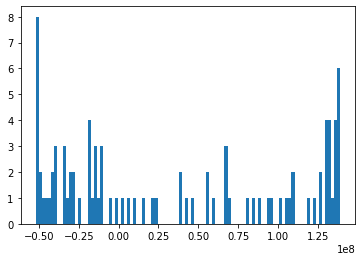

In [5]:
a=plt.hist(kc_vec[2].cpu().detach(),bins=100)

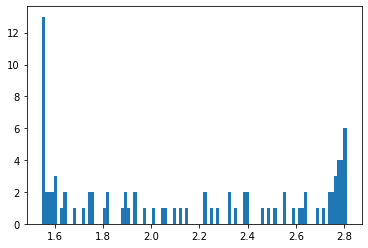

In [6]:
a=plt.hist(r_vec[2,:].cpu().detach(),bins=100)

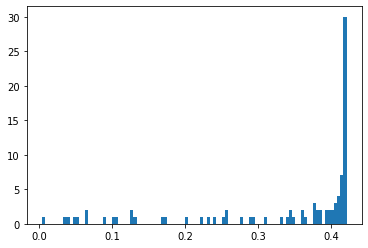

In [7]:
b=plt.hist(v_abs(dr_dt).cpu().detach(),100)

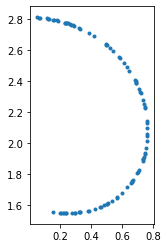

In [8]:
plt.scatter(r_vec.cpu()[0],r_vec.cpu()[2],marker='.')
plt.gca().set_aspect('equal')

In [9]:
c_r

0.4307471264367816

In [61]:
r_vec.cpu()

tensor([[ 5.6802e-01,  7.6138e-01,  3.1631e-01,  3.2245e-01,  7.0555e-01,
          5.5302e-01,  2.5610e-01,         nan,  4.2725e-01,         nan,
          5.0532e-01,  7.5479e-01,  2.3866e-01,  5.3371e-01,  7.3675e-01,
          7.2244e-01,  7.4459e-02,         nan,  5.8519e-01,  4.9419e-01,
          9.3062e-02,  7.6009e-01,  7.6155e-01,  2.9439e-01,  5.4558e-01,
          5.8441e-01,  7.4711e-01,  6.9408e-01,  2.2554e-01,  7.6336e-01,
          7.5450e-01,  5.3594e-01,  7.1111e-01,  4.0741e-02,  3.3135e-01,
                 nan,  5.4322e-01,  7.6488e-01,  3.8068e-01,         nan,
          7.0466e-01,  7.6206e-01,  5.1839e-01,         nan,  4.7912e-01,
          6.7047e-01,  7.4530e-01,  6.6860e-01,         nan,  1.8483e-01,
          3.1132e-01,  6.9664e-01,  7.5820e-01,  6.1367e-01,         nan,
          7.6465e-01,  7.5028e-01,  2.1110e-01,  7.3365e-01,  3.1178e-01,
          2.8504e-01,  7.5195e-01,  5.1933e-01,  6.8545e-01,         nan,
          3.9369e-01,  3.6235e-01,  6.

In [146]:
kc0

array([6.05617334e+08, 6.05617334e+08, 6.05617334e+08, ...,
       6.05617334e+08, 6.05617334e+08, 6.05617334e+08])